In [4]:
from karateclub import DeepWalk 

import networkx as nx
from sklearn.model_selection import train_test_split

from util.graph_tools import visualize_graph

import pandas as pd
from db.graph import Neo4JConnector

In [5]:
random_state = 4201312
node_color = {"Position": 0, "Champion": 1, "Player": 2}

neo4j = Neo4JConnector.create_from_config("../config.ini")

In [6]:
g = nx.DiGraph()
query = """CALL {
        MATCH (p:Player)-[pi:PLAYS_IN]->(pim:PlayerInMatch)
        WITH p, COUNT(pim.matchID) AS matchesPlayed 
        WHERE matchesPlayed > 10
        RETURN p
        LIMIT 100
    }
    MATCH (p)-[pc:PLAYS_CHAMP]->(c:Champion), (p)-[hp:HAS_POSITION]->(pos:Position)
    RETURN *"""

neo4j.create_graph_from_query(graph=g, query=query)
str(g)

'DiGraph with 186 nodes and 434 edges'

In [7]:
mapping = {node: i for i, node in enumerate(g.nodes)}  
mapping_rev = {i: node for i, node in enumerate(g.nodes)}  
g = nx.relabel_nodes(g, mapping)

In [8]:
node_infos = nx.get_node_attributes(g, "properties")

df_positions = nx.to_pandas_edgelist(g)
df_positions = df_positions[df_positions["type"] == "HAS_POSITION"]
df_positions["target_info"] = df_positions.target.apply(lambda x: node_infos[x])
df_positions["source_info"] = df_positions.source.apply(lambda x: node_infos[x])
df_positions

,source,target,properties,type,target_info,source_info
0,1,2,{'winningRate': 6.0},HAS_POSITION,"{'positionID': 'BOT', 'name': 'Botlane'}",{'accountID': 'v17WAJ1uDcAGWOvjr3E8erH354m04nJ...
6,8,9,{'winningRate': 0.6},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'vhxgfZVnErOfzYQ7wjeaFh1K6nR2j5-...
8,11,9,{'winningRate': 0.46153846153846156},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'n4ZSOu3j2z9htU0PITMyRWTebtXB2pr...
14,16,17,{'winningRate': 0.5},HAS_POSITION,"{'positionID': 'TOP', 'name': 'Toplane'}",{'accountID': 'nxKHRVKnmey3-mgzewMr4I8BKG8Gqup...
20,23,24,{'winningRate': 0.4375},HAS_POSITION,"{'positionID': 'SUP', 'name': 'Support'}",{'accountID': 'N40gE4B6zp4-fxqZEqq9misaD4HXVdV...
...,...,...,...,...,...,...
408,177,9,{'winningRate': 0.4444444444444444},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'zlM3gASiG4IDVojvImjrOKDvmJOEU0l...
414,179,24,{'winningRate': 0.8461538461538461},HAS_POSITION,"{'positionID': 'SUP', 'name': 'Support'}",{'accountID': 'JRQyVgEga4KyYACGtNRbuTPsjS0rbH4...
420,181,38,{'winningRate': 0.8},HAS_POSITION,"{'positionID': 'JGL', 'name': 'Jungle'}",{'accountID': 'R_BUPPLlN13kPOeqnQGbfkAWDEJi0mb...
423,183,9,{'winningRate': 0.6666666666666666},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'eDpW9xwZ3GRmpYJ0FAxiT4zotUtA0QN...


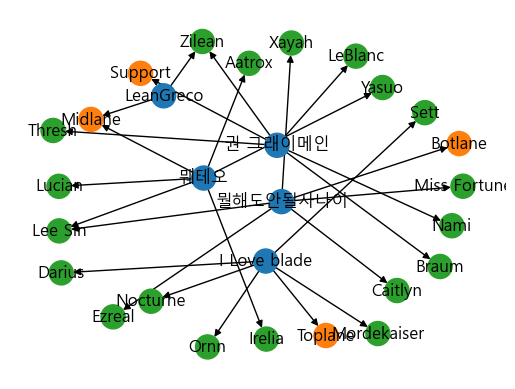

In [9]:
nodes_types = nx.get_node_attributes(g, 'type')
nodes_player = [node for node in nodes_types if nodes_types[node] == "Player"]
nodes_champion = [node for node in nodes_types if nodes_types[node] == "Champion"]
nodes_position = [node for node in nodes_types if nodes_types[node] == "Position"]

subgraph = nx.DiGraph(g.subgraph(nodes_champion + nodes_position + nodes_player[:5]))
subgraph.remove_nodes_from([node for node, degree in dict(subgraph.degree()).items() if degree == 0])
visualize_graph(subgraph)

In [10]:
edges_train, edges_test = train_test_split(df_positions, test_size=0.1, random_state=random_state)
len(edges_train), len(edges_test)

(68, 8)

In [11]:
g_train = g.copy()
g_train.remove_edges_from(edges_test[["source", "target"]].values)

In [12]:
model = DeepWalk(walk_length=100, dimensions=64, window_size=5) 
model.fit(g_train) 

In [13]:
embedding = model.get_embedding() 

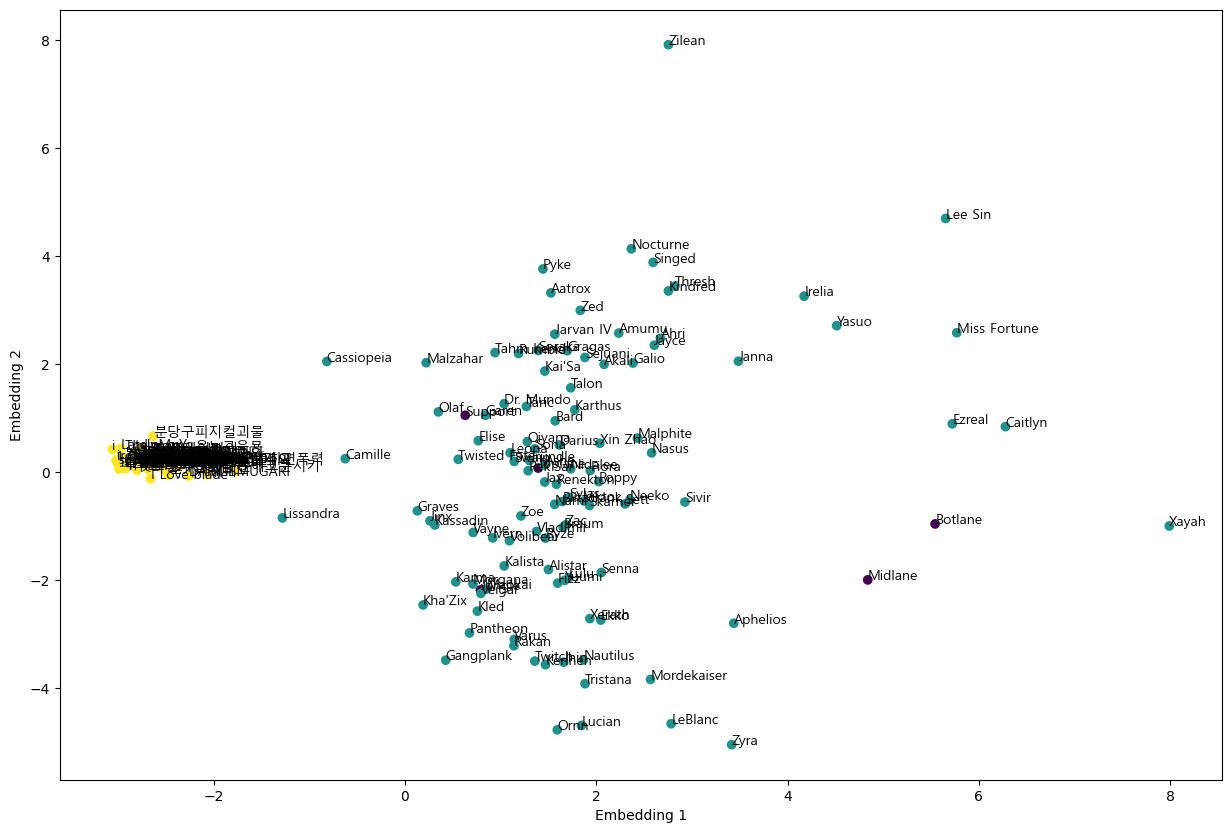

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# take first 100 nodes 
nodes =list(range(len(g.nodes))) 
  
# plot nodes graph 
def plot_nodes(node_no): 
    X = embedding[node_no] 

    
    pca = PCA(n_components=2) 
    pca_out= pca.fit_transform(X) 
      
      
    plt.figure(figsize=(15,10)) 
    plt.scatter(pca_out[:, 0], pca_out[:, 1], c=[node_color[g.nodes[i]["type"]] for i in node_no]) 
    for i, node in enumerate(node_no):
        plt.annotate(g.nodes[node]["properties"]["name"], (pca_out[i, 0], pca_out[i, 1]), fontfamily="Malgun Gothic")
            
    plt.xlabel('Embedding 1') 
    plt.ylabel('Embedding 2') 
    plt.show() 
  
plot_nodes(nodes) 

In [20]:
embedding = pd.DataFrame(embedding)
embedding["node"] = g.nodes

In [19]:
embedding

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,node,type
0,1.016442,0.728238,-0.975490,-0.051347,-2.760720,0.907645,0.647446,-0.258656,0.012400,-2.002783,...,0.613929,0.585128,2.030801,1.116472,-1.183105,-1.938057,-0.205876,-0.533303,0,Champion
1,0.027482,0.044118,-0.029204,-0.000092,-0.103374,0.035839,0.018603,-0.020991,0.013956,-0.066092,...,0.028060,0.028729,0.061454,0.036086,-0.044445,-0.072834,0.000844,-0.003616,1,Player
2,1.475422,0.471780,-0.510843,-0.635059,-2.808791,1.043131,0.771761,-0.589477,0.105224,-1.668777,...,0.545593,0.675366,1.651431,1.127915,-0.564982,-0.935243,-0.634097,-0.213649,2,Position
3,0.161068,1.915857,-0.312169,0.327356,-1.728038,1.155196,-0.579733,-0.244472,0.096600,-0.774934,...,1.317804,-0.031940,1.205316,0.703004,-1.943246,-2.443117,-0.258479,0.308972,3,Champion
4,1.007582,1.829993,0.763091,-0.153220,-2.231188,1.238906,-1.637916,-1.231280,-0.237607,0.014470,...,0.724465,-0.255397,0.526408,0.713779,-2.529767,-3.196872,0.819492,1.034245,4,Champion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.010356,-0.015507,0.000655,0.006938,-0.005631,-0.004276,0.021446,-0.009309,-0.017092,-0.021870,...,-0.000448,0.018053,0.029651,-0.001164,0.012759,-0.002191,0.005961,-0.013270,181,Player
182,-0.310275,-0.237358,-0.477557,0.902644,-0.174540,-0.568400,0.929280,-0.095852,0.307231,-0.343826,...,-0.405170,0.254793,1.133775,-0.471238,-0.262072,-0.106147,0.129168,-0.339121,182,Champion
183,0.002416,0.009492,0.000855,0.016288,-0.004865,0.010607,0.001809,-0.003515,-0.022947,-0.003630,...,0.006859,0.016384,-0.010752,-0.009325,0.009064,-0.019640,-0.008385,-0.002287,183,Player
184,0.007576,0.016428,0.015023,-0.000682,0.009438,-0.005046,-0.020360,0.003183,0.006546,0.000728,...,-0.007418,-0.000584,0.004966,0.005566,0.006140,-0.021566,0.003257,0.008189,184,Player


In [21]:
df_positions

,source,target,properties,type,target_info,source_info
0,1,2,{'winningRate': 6.0},HAS_POSITION,"{'positionID': 'BOT', 'name': 'Botlane'}",{'accountID': 'v17WAJ1uDcAGWOvjr3E8erH354m04nJ...
6,8,9,{'winningRate': 0.6},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'vhxgfZVnErOfzYQ7wjeaFh1K6nR2j5-...
8,11,9,{'winningRate': 0.46153846153846156},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'n4ZSOu3j2z9htU0PITMyRWTebtXB2pr...
14,16,17,{'winningRate': 0.5},HAS_POSITION,"{'positionID': 'TOP', 'name': 'Toplane'}",{'accountID': 'nxKHRVKnmey3-mgzewMr4I8BKG8Gqup...
20,23,24,{'winningRate': 0.4375},HAS_POSITION,"{'positionID': 'SUP', 'name': 'Support'}",{'accountID': 'N40gE4B6zp4-fxqZEqq9misaD4HXVdV...
...,...,...,...,...,...,...
408,177,9,{'winningRate': 0.4444444444444444},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'zlM3gASiG4IDVojvImjrOKDvmJOEU0l...
414,179,24,{'winningRate': 0.8461538461538461},HAS_POSITION,"{'positionID': 'SUP', 'name': 'Support'}",{'accountID': 'JRQyVgEga4KyYACGtNRbuTPsjS0rbH4...
420,181,38,{'winningRate': 0.8},HAS_POSITION,"{'positionID': 'JGL', 'name': 'Jungle'}",{'accountID': 'R_BUPPLlN13kPOeqnQGbfkAWDEJi0mb...
423,183,9,{'winningRate': 0.6666666666666666},HAS_POSITION,"{'positionID': 'MID', 'name': 'Midlane'}",{'accountID': 'eDpW9xwZ3GRmpYJ0FAxiT4zotUtA0QN...


TODO: KMeans